In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv('fraud_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

#### Correcting inconsistency in column name

In [4]:
df = df.rename(columns={'oldbalanceOrg':'oldbalanceOrig'})
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### The columns are:
* **step:** A timestamp / date variable that has been made arbitrary for data privacy.
* **type:** The type of transaction. type is our only categorical independent variable. Categories include [cash_in, cash_out, debit, payment, transfer].
* **amount:** Size of transaction.
* Next 6 columns are account level info:
  * Suffix **Orig** refers to the originating account of the transaction.
  * Suffix **Dest** refers to destination account of the transaction.
  * Prefix **name** refers to Account ID number. An 'M' prefix, e.g. 'M1979...' denotes a merchant account. The name will not be directly used as a model feature, although we can extract the merchant prefix to create a boolean indicator variable. One thing to note is that balance data is not available for merchants. For merchants, the placeholder value for balances is zero.
  * Prefix **oldbalance** refers to account balance before transaction.
  * Prefix **newbalance** refers to account balance after transaction (and also great pair of shoes!)
* **isFraud:** Our label / dependent variable—whether the transaction was made by a fraudulent agent. 1 for fraudulent, 0 for not fraudulent.
* **isFlaggedFraud:** Whether the transaction was flagged as fraud by the "business model". Since we are doing our own prediction here, we will ignore this variable.

#### Missing data


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.isnull().values.any()

False

As we can see from our analysis above, there are no missing values in the dataset.

#### Data Imbalance
As is often the case with fraud data like this, the dataset is highly imbalanced. Over 99.8% of the transaction records are non-fraudulent. Because only a tiny fraction of the dataset represents fraud, fraudulent transactions are likely to be under-represented in our model. If unaddressed, data imbalance can cause issues, such as misleading accuracy metrics in the model. The model may attempt to label every transaction as non-fraudulent, and since any randomly given transaction is highly likely to be non-fraudulent, a high accuracy will be reported, despite incorrectly classifying all fraudulent transactions as non-fraudulent. We should take care to compare model performance metrics considering fraudulent and non-fraudulent data independently.

In [7]:
print('The proportion of total transactions labeled as fraudulent is',df['isFraud'].value_counts()[1]/df['isFraud'].size)

The proportion of total transactions labeled as fraudulent is 0.001290820448180152


0    6354407
1       8213
Name: isFraud, dtype: int64

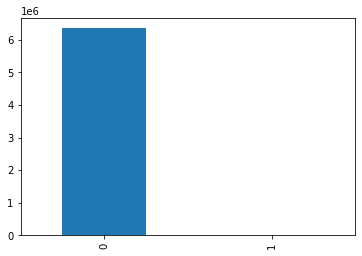

In [8]:
df['isFraud'].value_counts().plot(kind='bar')
df['isFraud'].value_counts()

#### Analyzing the features
Step

**step** is our time variable. Most transactions occur in the first half of our time sample range.

<AxesSubplot:>

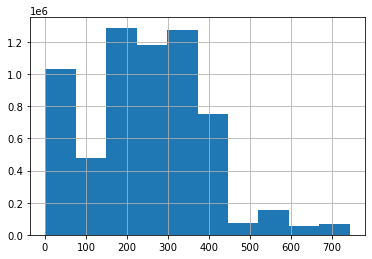

In [9]:
df['step'].hist()

**Amount**

Amounts are skewed right—the vast majority of transactions are low amounts.

<AxesSubplot:xlabel='amount', ylabel='Count'>

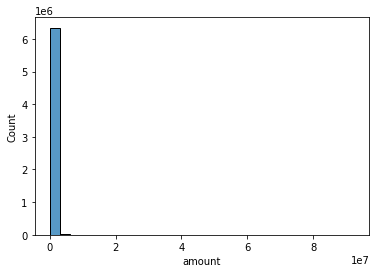

In [10]:
sns.histplot(data=df['amount'], bins=30)

In [11]:
print('The average transaction amount is',df['amount'].mean())

The average transaction amount is 179861.90354912292


**Type**

For transaction type, cash withdrawals and payment transactions are the most common, while transfers and debits make up a smaller fraction of the data.

<AxesSubplot:>

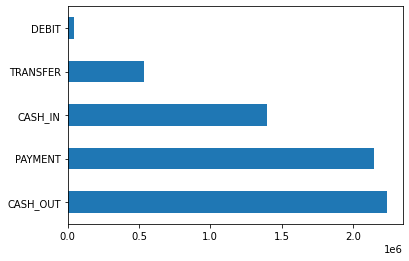

In [12]:
df['type'].value_counts().plot(kind='barh')

**oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest**

Balance numbers show patterns similar to amount, i.e. heavily skewed to the right. We will touch on correlation between these variables next.

array([[<AxesSubplot:title={'center':'oldbalanceOrig'}>,
        <AxesSubplot:title={'center':'newbalanceOrig'}>],
       [<AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>]], dtype=object)

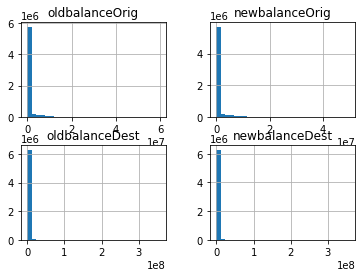

In [13]:
df[['oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].hist(bins=30)

In [14]:
print('Average balance values:')

with pd.option_context('display.float_format','{:.2f}'.format):
    print(df[['oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].mean())

Average balance values:
oldbalanceOrig    833883.10
newbalanceOrig    855113.67
oldbalanceDest   1100701.67
newbalanceDest   1224996.40
dtype: float64


#### Correlation
Let's look at correlation between the independent variables.

<AxesSubplot:>

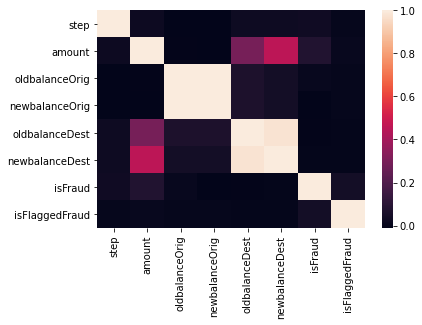

In [15]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Given an account, **oldbalance** and **newbalance** are highly correlated with each other. That makes sense, because transaction amounts are typically a small proportion of account balances. In other words, account balances have high correlations with themselves.

What's odd is that while **amount** has some correlation with **oldbalanceDest** and **newbalanceDest**, it has very low correlations with **oldbalanceOrig** and **newbalanceOrig**. Let's check pairwise scatterplots for these variables, starting with amount vs. oldbalanceOrig and newbalanceOrig.

<ipython-input-16-689f8cadf543>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


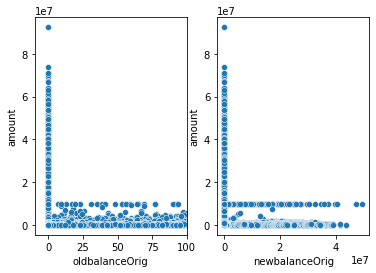

In [16]:
fig, ax = plt.subplots(1,2)

ax[0].set_xlim([-10,100])

sns.scatterplot(data=df, x='oldbalanceOrig', y='amount', ax=ax[0])
sns.scatterplot(data=df, x='newbalanceOrig', y='amount', ax=ax[1])

fig.show()

Some interesting patterns here. There is a notably high frequency of transactions with the amount of exactly 10,000,000.

There are also quite a few transactions where the amount is greater than 10,000,000, along the left edge of the scatter plots. These transactions are exclusively transfers where the destination account receives the change of the transaction amount and the originating account field has zero balance. None of these transactions are labeled as fraudulent.

In [17]:
df[df['amount']>10000000]['type'].value_counts()

TRANSFER    2443
Name: type, dtype: int64

Checking if any of these amounts are fraudulent

In [18]:
df[df['amount']>10000000]['isFraud'].value_counts()

0    2443
Name: isFraud, dtype: int64

As we can see from the analysis above, none of the transfer transactions are fraudulent

In [19]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

df[df['amount']>10000000]

<IPython.core.display.Javascript object>

,step,type,amount,isFraud,isFlaggedFraud


Below, we can see in these pairwise plots between **amount** and **oldbalanceDest / newbalanceDest** that they exhibit more evenly random distributions. There appears to be a very weak positive relationship between amounts and destination account balances, which we observed earlier in the correlation matrix.

<ipython-input-20-93744aeb6df4>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


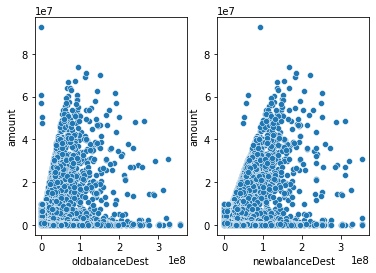

In [20]:
fig, ax = plt.subplots(1,2)

sns.scatterplot(data=df, x='oldbalanceDest', y='amount', ax=ax[0])
sns.scatterplot(data=df, x='newbalanceDest', y='amount', ax=ax[1])

fig.show()

#### Feature Engineering
We can create some additional columns derived from existing data for features that may improve the model performance.

**Merchant Accounts**

As stated earlier, merchant account numbers are denoted by the 'M' prefix. We will capture this information in a boolean variable that the model can use as a feature.

In [2]:
df1 = pd.read_csv('fraud.csv')

In [4]:
df1['merchant'] = df1['nameDest'].str.contains('M')

df1.head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,True
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,True
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,False
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,True
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,True
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,True
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,True
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,True
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,False


We can see here that transactions involving merchant accounts are never fraudulent, while those transactions not involving merchants are sometimes fraudulent.

In [5]:
df1[['isFraud','merchant']].value_counts()

isFraud  merchant
0        False       693560
         True        353873
1        False         1142
dtype: int64

Looking at the rows where isFraud==1

In [6]:
df1[df1['isFraud']==1].head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,False
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,0,False
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0,False
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,0,False
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0,False
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,0,False
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,0,False
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0,False
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,0,False


All fraudulent transactions fall under the CASH_OUT or TRANSFER type.

#### Counts of each transaction type for fraudulent transactions

In [8]:
df1[df1['isFraud']==1]['type'].value_counts()

CASH_OUT    578
TRANSFER    564
Name: type, dtype: int64

As described in the dataset documentation, these transactions typically involve the fraud agent pulling large amounts out of the targeted accounts. Let's see if we can demonstrate some of these characteristics by creating and observing columns that show the change in account balances due to a transaction. We will use the convention of subtracting old balance from new, so that the difference value is positive if the account balance is higher after the transaction, and vice versa.

In [9]:
df1['balancediffOrig'] = df1['newbalanceOrig'] - df1['oldbalanceOrig']
df1['balancediffDest'] = df1['newbalanceDest'] - df1['oldbalanceDest']

df1.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant,balancediffOrig,balancediffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,True,-9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,True,-1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,-181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,False,-181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,True,-11668.14,0.0


In the box plots below, we can see that between the fraudulent and non-fraudulent data, **balancediffOrig** shows very contrasting distributions. For **isFraud==1**, the values tend to be much more negative, implying that these transactions are indeed moving large amounts of funds out of the originating account. This feature could end up having significant impact on the model predictions.

<AxesSubplot:xlabel='isFraud', ylabel='balancediffOrig'>

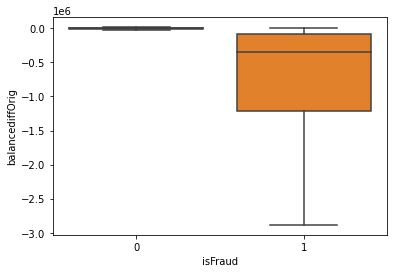

In [10]:
sns.boxplot(x="isFraud", y="balancediffOrig", data=df1,showfliers=False)

The difference is less stark with balancediffDest, and the difference values also tend to be more positive, indicating that the transactions tend to move funds into the destination account.

<AxesSubplot:xlabel='isFraud', ylabel='balancediffDest'>

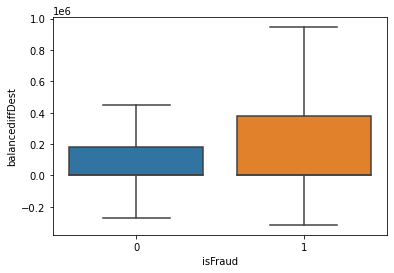

In [11]:
sns.boxplot(x="isFraud", y="balancediffDest", data=df1, showfliers=False)

A commonality in these last two plots was that the balance difference values for isFraud==1 had more variance and spread. This may be because our sample size for fraudulent data is much smaller. By nature, smaller samples are likely to exhibit higher variability.

#### Preprocessing
We will now prepare the data for model input. Subsetting the dataframe to only select the variables we will use as model features, as well as the label for classification.

In [12]:
features = ['step',
            'type',
            'amount',
            'oldbalanceOrig',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest',
            'balancediffOrig',
            'balancediffDest',
            'merchant']

label = ['isFraud']

In [13]:
X = df1[features]
y = df1[label]

#### One-Hot Encoding
**type** is a categorical variable, which will need to be encoded as separate boolean dummy variables for each unique value of account type to be used by the model.

#### Before Encoding

In [14]:
X.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,balancediffOrig,balancediffDest,merchant
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,True
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,True
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,False
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,False
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,True


#### After Encoding

In [15]:
X = X.join(pd.get_dummies(X[['type']], prefix='type')).drop(['type'], axis=1)

X.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,balancediffOrig,balancediffDest,merchant,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,True,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,True,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,False,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,False,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,True,0,0,0,1,0


#### Modeling
We will first split the data into training and test sets, with a 70/30 split. This is done to measure and avoid possible overfitting, an issue in which the model is too specific to the dataset it trains on, and is not as generalizable to out-of-sample data. By measuring the model's performance on separate data, we have a more fair assessment of the model's ability to extrapolate its predictions to new or unseen information.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(734002, 14)
(734002, 1)
(314573, 14)
(314573, 1)


#### Decision Tree
At a high level, a decision tree model works by sequentially splitting the dataset along value thresholds of the predictor variables. The splits are determined by a criteria that quantifies how different two sets of data are (by default, Gini impurity). For example, if fraudulent transactions most frequently occur with amounts over 1,000,000, while non-fraudulent transactions are more frequently of lower amounts, our decision tree is likely to use amount as a node that splits our dataset into transactions of those over 1,000,000 and those that are less. The decision tree then considers each of those two groups and attempts to perform another split on one of the other features, and so on, until the split groups have zero impurity (all the members of each group have the same classification). While in actuality the data does not contain such explicit separations, this is the general logic used by the algorithm. In a basic sense, it can be thought of as categorizing the data based on its features. It repeats the process iteratively on each branch until an end (leaf) is reached, hence the "tree".

An advantage of using decision trees is that the results are highly interpretable and easy to visualize. This means we will be able to see exactly how the decision tree constructs itself, and what features it prioritizes in its construction. It will show us how the data is being split and by what values for each feature will lead to a certain classification. The same cannot be said for certain "black box" methods of modeling, such as neural networks—which despite their potential for high performance, are often too complex to be intuitively understood and explained, even by the model developer.

Let's implement the decision tree and measure its performance.

In [17]:
dt_clf = DecisionTreeClassifier(random_state=10)

dt_clf = dt_clf.fit(X_train,y_train)

y_pred = dt_clf.predict(X_test)

Now that the model has been fit, we can create predictions for the test set and see how they compare to the actual data. A sample of the predictions can be seen below.

In [18]:
result = pd.DataFrame({'actual':y_test['isFraud'], 'predicted':y_pred})
result[result['actual']==1]

,actual,predicted
464597,1,1
1030321,1,1
985996,1,1
1030469,1,1
1030428,1,1
...,...,...
1030698,1,1
576348,1,1
1030702,1,1
1044988,1,0


#### Accuracy of the Model
The **sklearn.metrics.classification_report** function gives us a nice printout for assessing performance, including precision, recall, and f1-score for each of the classes independently. The separation for the classes is important especially when dealing with imbalanced data, as we are now. All of these metrics range from 0 to 1, higher numbers representing better accuracy.
* **Precision:** The proportion of values selected by the model that should be selected. Precision is penalized by having more false positives.
* **Recall:** The proportion of values that should be selected, that are actually selected by the model. Recall is penalized by having more false negatives.
* **F1 score:** The harmonic mean of precision and recall.

Another measure we can use is Area Under Curve (AUC), which refers to the area under the ROC curve, which is a plot of the true positive rate against the false positive rate. AUC also ranges from 0 to 1 and is frequently used as a quick way to compare model performance.

In [19]:
print(metrics.classification_report(y_test, y_pred))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('AUC:', metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314246
           1       0.82      0.82      0.82       327

    accuracy                           1.00    314573
   macro avg       0.91      0.91      0.91    314573
weighted avg       1.00      1.00      1.00    314573

AUC: 0.9096952394431982


As mentioned above, in dealing with imbalanced data like this, overall accuracy is not a particularly useful metric. However, we can see the metrics for the **isFraud==1** class by itself. A recall of 0.82 on this class essentially tells us that we correctly predicted 82% of the truly fraudulent data.

#### Visualizing the Decision Tree
Sklearn also provides a function for creating a visual output for the decision tree model. For brevity, only the first couple of levels are printed here; the entire tree can be much larger. This output illustrates the nature of the algorithm and particularly the exact set of conditions required to predict one class or the other.

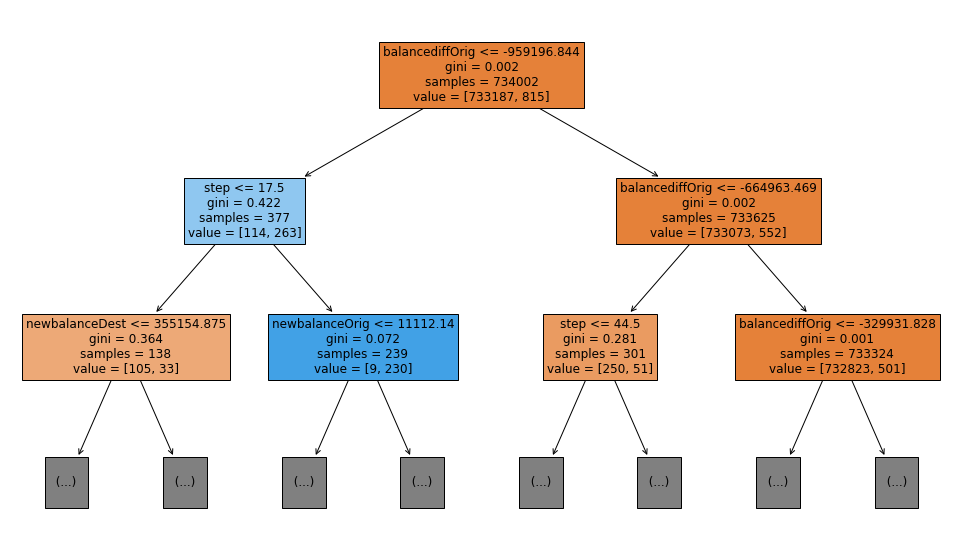

In [20]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(17,10))
_ = plot_tree(dt_clf, max_depth=2, feature_names=list(X_train.columns), filled=True, fontsize=12)

#### Features Importance
In order to objectively determine each features' influence on the predictions, we can calculate, summed up for each feature, the amount by which it reduces impurity in each node it represents. Sklearn provides these values in the **feature_importances_** attribute of **DecisionTreeClassifier**.

In [21]:
fi = pd.DataFrame({'features':X_train.columns,'importance':dt_clf.feature_importances_}).sort_values(by=['importance'], ascending=False)
fi

,features,importance
0,step,0.379542
6,balancediffOrig,0.283205
1,amount,0.088257
7,balancediffDest,0.067682
5,newbalanceDest,0.058766
2,oldbalanceOrig,0.041475
13,type_TRANSFER,0.034974
4,oldbalanceDest,0.021730
3,newbalanceOrig,0.013532
12,type_PAYMENT,0.010828


<AxesSubplot:xlabel='importance', ylabel='features'>

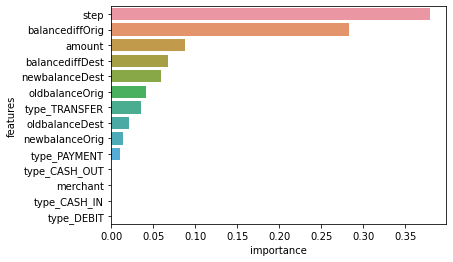

In [22]:
sns.barplot(x="importance", y="features", data=fi)

This tells us that the most influential features to the model are balance changes and newbalanceDest. Whether or not the transaction is a transfer is also important. This confirms our earlier supposition based on the data documentation that fraudulent transactions are often characterized by transfers of large amounts.

#### Saving the Model

In [23]:
import joblib
filename = 'fraud_detection_model.pkl'
joblib.dump(dt_clf, filename)

['fraud_detection_model.pkl']

In [ ]:
# To load the model for reuse
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)